In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from triqs.gf import *
from h5 import HDFArchive

# 3. CSC with QE/W90 and HubbardI: total energy in Ce2O3

Disclaimer:

* These can be heavy calculations. Current parameters won't give converged solutions, but are simplified to deliver results on 10 cores in 10 minutes.
* The interaction values, results etc. might not be 100% physical and are only for demonstrative purposes!

The goal of this tutorial is to demonstrate how to perform fully charge self-consistent DFT+DMFT calculations in solid_dmft using [Quantum Espresso](https://www.quantum-espresso.org/) (QE) and [Wannier90](http://www.wannier.org/) (W90) for the DFT electronic structure using the [HubbardI solver](https://triqs.github.io/hubbardI/latest/index.html).

We will use Ce$_2$O$_3$ as an example and compute the total energy for the $s=0\%$ experimental ground state structure. To find the equilibrium structure in DFT+DMFT one then repeats these calculations variing the strain in DFT as was done in Fig. 7 of [arxiv:2111.10289 (2021)](https://arxiv.org/abs/2111.10289.pdf):

<img src="./tenergy_ce2o3.png" alt="drawing" width="800"/>

In the case of Ce$_2$O$_3$ it turns out that in fact DFT+DMFT predicts the same ground state as is found experimentally, while DFT underestimates, and DFT+DMFT in the one-shot approximation overestimates the lattice parameter, respectively.

The tutorial will guide you through the following steps: 

* perpare the input for the DFT and DMFT calculations using Quantum Espresso and Wannier90 and TRIQS
* run a charge self-consistent calculation for Ce$_2$O$_3$
* analyse the change in the non-interacting part of the charge density using TRIQS
* analyse the convergence of the total energy and the DMFT self-consistency

We set `path` variables to the reference files:

In [2]:
path = './ref/'

## 1. Input file preparation

The primitive cell of Ce$_2$O$_3$ contains 2 Ce atoms with 7 $f$-electrons each, so 14 in total. They are relatively flat, so there is no entanglement with any other band.
We start from relaxed structure as usual. All files corresponding to this structure should be prepared and stored in a separate directory (`save/` in this case). For details please look at Section III in [arxiv:2111.10289 (2021)](https://arxiv.org/abs/2111.10289.pdf).

### DFT files

All input files are of the same kind as usual, unless stated otherwise:

Quantum Espresso:

1. [ce2o3.scf.in](./dft_input/ce2o3.scf.in)
2. [ce2o3.nscf.in](./dft_input/ce2o3.nscf.in)

    - explicit k-mesh
    ```
    &system
        nosym            = .true.
        dmft             = .true.
    ```
3. [ce2o3.mod_scf.in](./dft_input/ce2o3.mod_scf.in): new!

    - explicit k-mesh
    ```
    &system
        nosym            = .true.
        dmft             = .true.
        dmft_prefix      = seedname
    &electrons
        electron_maxstep = 1
        mixing_beta      = 0.3
    ```

Optionally:

- `seedname.bnd.in`
- `seedname.bands.in`
- `seedname.proj.in`

Wannier90:

1. [ce2o3.win](./dft_input/ce2o3.win)

    ```
        write_u_matrices = .true.
    ```
2. [ce2o3.pw2wan.in](./dft_input/ce2o3.pw2wan.in)

### DMFT

1. Wannier90Converter: [ce2o3.inp](./dft_input/ce2o3.inp)
2. solid_dmft: [dmft_config.toml](./dmft_config.toml)

Here we'll discuss the most important input flags for solid_dmft:

In [1]:
!cat ./dmft_config.toml

[general]
seedname = "ce2o3"
jobname = "b10-U6.46-J0.46"
csc = true

eta = 0.5
n_iw = 100
n_tau = 5001

n_iter_dmft_first = 2
n_iter_dmft_per = 1
n_iter_dmft = 5

block_threshold = 1e-03

h_int_type = "density_density"
U = 6.46
J = 0.46
beta = 10
prec_mu = 0.1

sigma_mix = 1.0
g0_mix = 1.0
dc_type = 0
dc = true
dc_dmft = true
calc_energies = true

h5_save_freq = 1

[solver]
type = "hubbardI"
n_l = 15
store_solver = false
measure_G_l = false
measure_density_matrix = true

[dft]
dft_code = "qe"
n_cores = 10
mpi_env = "default"
projector_type = "w90"
dft_exec = "pw.x"
w90_tolerance = 1.e-1


Of course you'll have to switch `csc` on to perform the charge self-consistent calculations. Then we choose the HubbardI Solver, set the number of Legendre polynomials, Matsubara frequencies $i\omega_n$ and imaginary time grid points $\tau$. In this calculation we perform five iterations in total, of which the two first ones are one-shot DMFT iterations, followed by three DFT and three DMFT steps.
For the interaction Hamiltonian we use `density_density`. Note that you unlike the Kanamori Hamiltonian, this one is not rotationally invariant, so the correct order of the orbitals must be set (inspect the projections card in `ce2o3.win`). We must also use `dc_dmft` and `calc_energies`, since we are interested in total energies.
Finally, we will specify some details for the DFT manager, i.e. to use QE, W90 and the tolerance for the mapping of shells. Note that this value should in general be $1e-6$, but for demonstration purposes we reduce it here. If `dft_exec` is empty, it will assume that `pw.x` and other QE executables are available.

## 2. Running DFT+DMFT

Now that everything is set up, copy all files from `./dft_input` and start the calculation:
```
cp dft_input/* .
mpirun solid_dmft > dmft.out &
```

You will note that for each DFT step solid_dmft will append the filenames of the DFT Ouput with a unique identifier `_itXY`, where `XY` is the total iteration number. This allows the user to keep track of the changes within DFT. For the W90 `seedname.wout` and `seedname_hr.dat` files the seedname will be renamed to `seedname_itXY`. If the QE `seedname_bands.dat`, and `seedname_bands.proj` are present, they will be saved, too.

You can check the output of the calculations while they are running, but since this might take a few minutes, we'll analyse the results of the reference data in `/ref/ce2o3.h5`. You should check if the current calculation reproduces these results.

## 3. Non-interacting Hamiltonian and convergence analysis
### Tight-binding Hamiltonian

Disclaimer: the bands shown here are only the non-interacting part of the charge density. Only the first iteration corresponds to a physical charge density, namely the Kohn-Sham ground state charge density.

The first thing to check is whether the DFT Hamiltonian obtained from Wannier90 is correct. For this we use the tools available in `triqs.lattice.utils`.
Let us first get the number of iterations and Fermi levels from DFT:

In [4]:
e_fermi_run = !grep "DFT Fermi energy" triqs.out
e_fermi_run = [float(x.split('DFT Fermi energy')[1].split('eV')[0]) for x in e_fermi_run]
n_iter_run = !ls ce2o3_it*_hr.dat
n_iter_run = sorted([int(x.split('_it')[-1].split('_')[0]) for x in n_iter_run])
print(f'Fermi levels: {e_fermi_run}')
print(f'iteration counts: {n_iter_run}')

Fermi levels: [14.3557, 14.42, 14.4619, 14.495]
iteration counts: [1, 3, 4, 5]


Starting serial run at: 2022-03-25 12:42:36.663824


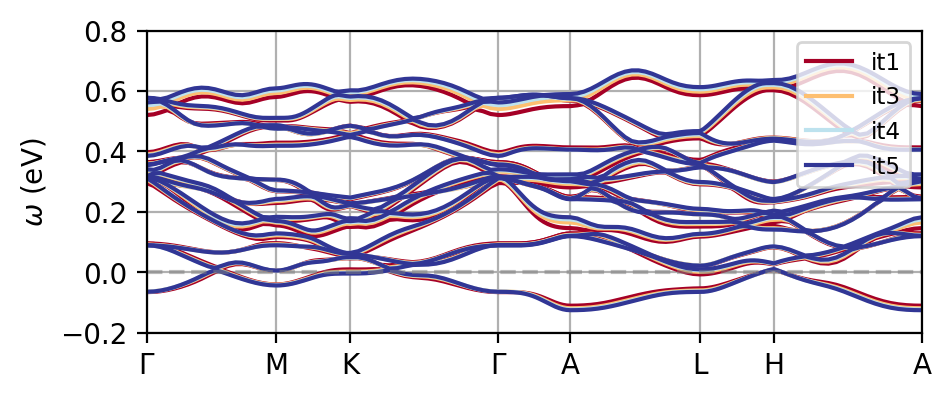

In [5]:
from matplotlib import cm
from triqs.lattice.utils import TB_from_wannier90, k_space_path

# define a path in BZ
G = np.array([ 0.00,  0.00,  0.00])
M = np.array([ 0.50,  0.00,  0.00])
K = np.array([ 0.33,  0.33,  0.00])
A = np.array([ 0.00,  0.00,  0.50])
L = np.array([ 0.50,  0.00,  0.50])
H = np.array([ 0.33,  0.33,  0.50])
k_path = [(G, M), (M, K), (K, G), (G, A), (A, L), (L, H), (H, A)]
n_bnd = 14
n_k = 20

fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=200)

for (fermi, n_iter, cycle) in [(e_fermi_run, n_iter_run, cm.RdYlBu)]:

    col_it = np.linspace(0, 1, len(n_iter))
    for ct, it in enumerate(n_iter):

        # compute TB model
        h_loc_add = - fermi[ct] * np.eye(n_bnd) # to center bands around 0
        tb = TB_from_wannier90(path='./', seed=f'ce2o3_it{it}', extend_to_spin=False, add_local=h_loc_add)

        # compute dispersion on specified path
        k_vec, k_1d, special_k = k_space_path(k_path, num=n_k, bz=tb.bz)
        e_val = tb.dispersion(k_vec)

        # plot
        for band in range(n_bnd):
            ax.plot(k_1d, e_val[:,band].real, c=cycle(col_it[ct]), label=f'it{it}' if band == 0 else '')

    
ax.axhline(y=0,zorder=2,color='gray',alpha=0.5,ls='--')
ax.set_ylim(-0.2,0.8)
ax.grid(zorder=0)
ax.set_xticks(special_k)
ax.set_xticklabels([r'$\Gamma$', 'M', 'K', r'$\Gamma$', 'A', 'L', 'H', 'A'])
ax.set_xlim([special_k.min(), special_k.max()])
ax.set_ylabel(r'$\omega$ (eV)')
ax.legend(fontsize='small')

Note that since this is an isolated set of bands, we don't have to worry about the disentanglement window here. Pay attention if you do need to use disentanglement though, and make sure that the configuration of Wannier90 works throughout the calculation!

You see that one of the effects of charge self-consistency is the modificiation of the non-interacting bandstructure. The current results are far from converged, so make sure to carefully go through convergence tests as usual if you want reliable results. The figure below shows the difference to the reference data, which is quite substantial already at the DFT level.

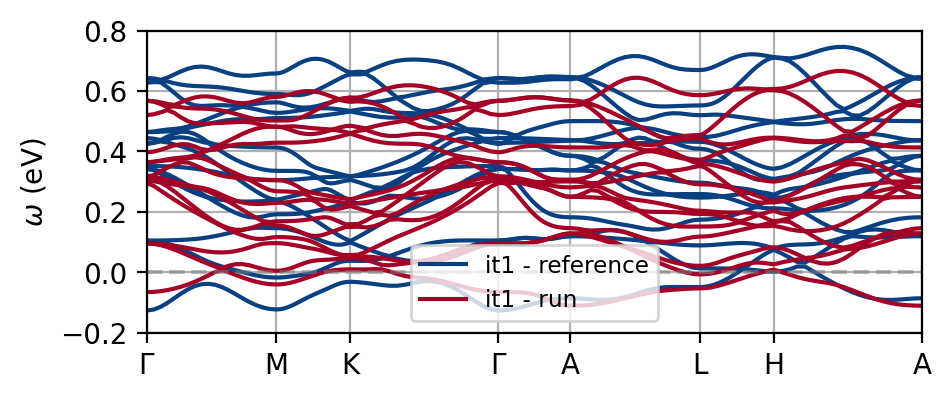

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=200)

e_fermi_ref = [14.7437]
for (fermi, n_iter, path_w90, cycle, label) in [(e_fermi_ref, [1], path, cm.GnBu_r, 'reference'), (e_fermi_run, [1], './', cm.RdYlBu, 'run')]:

    col_it = np.linspace(0, 1, len(n_iter))
    for ct, it in enumerate(n_iter):

        # compute TB model
        h_loc_add = - fermi[ct] * np.eye(n_bnd) # to center bands around 0
        tb = TB_from_wannier90(path=path_w90, seed=f'ce2o3_it{it}', extend_to_spin=False, add_local=h_loc_add)

        # compute dispersion on specified path
        k_vec, k_1d, special_k = k_space_path(k_path, num=n_k, bz=tb.bz)
        e_val = tb.dispersion(k_vec)

        # plot
        for band in range(n_bnd):
            ax.plot(k_1d, e_val[:,band].real, c=cycle(col_it[ct]), label=f'it{it} - {label}' if band == 0 else '')

    
ax.axhline(y=0,zorder=2,color='gray',alpha=0.5,ls='--')
ax.set_ylim(-0.2,0.8)
ax.grid(zorder=0)
ax.set_xticks(special_k)
ax.set_xticklabels([r'$\Gamma$', 'M', 'K', r'$\Gamma$', 'A', 'L', 'H', 'A'])
ax.set_xlim([special_k.min(), special_k.max()])
ax.set_ylabel(r'$\omega$ (eV)')
ax.legend(fontsize='small')

### Convergence

To check the convergence of the impurity Green's function and total energy you can look into the hdf5 Archive:

In [7]:
with HDFArchive('./ce2o3.h5','r') as h5:
    observables = h5['DMFT_results']['observables']
    convergence = h5['DMFT_results']['convergence_obs']
    
with HDFArchive(path + 'ce2o3.h5','r') as h5:
    ref_observables = h5['DMFT_results']['observables']
    ref_convergence = h5['DMFT_results']['convergence_obs']

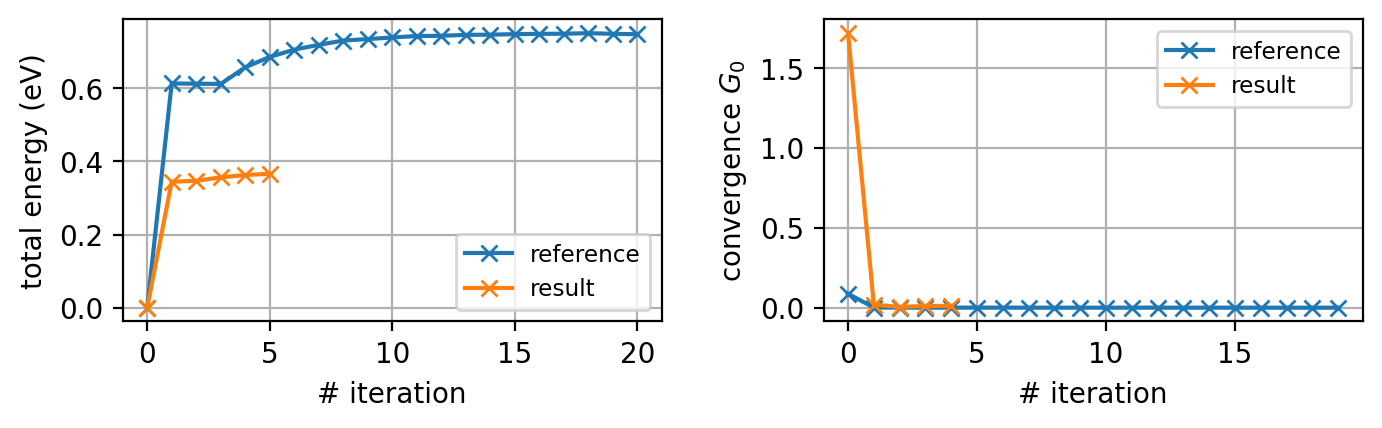

In [8]:
fig, ax = plt.subplots(1,2, figsize=(8, 2), dpi=200)

ax[0].plot(ref_observables['E_tot']-np.min(ref_observables['E_tot']), 'x-', label='reference')
ax[0].plot(observables['E_tot']-np.min(observables['E_tot']), 'x-', label='result')

ax[1].plot(ref_convergence['d_G0'][0], 'x-', label='reference')
ax[1].plot(convergence['d_G0'][0], 'x-', label='result')

ax[0].set_ylabel('total energy (eV)')
ax[1].set_ylabel(r'convergence $G_0$')

for it in range(2):
    ax[it].set_xlabel('# iteration')
    ax[it].xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax[it].grid()
    ax[it].legend(fontsize='small')

fig.subplots_adjust(wspace=0.3)

Note that the total energy jumps quite a bit in the first iteration and is constant for the first two (three) one-shot iterations in this run (the reference data) as expected. Since the HubbardI solver essentially yields DMFT-convergence after one iteration (you may try to confirm this), the total number of iterations necessary to achieve convergence is relatively low.

This concludes the tutorial. The following is a list of things you can try next:

* improve the accuracy of the results by tuning the parameters until the results agree with the reference    
* try to fnd the equilibrium lattice paramter by repeating the above calculation of the total energy for different cell volumes